In [2]:
import csv
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Activation, Dropout, MaxPooling2D
from keras.layers.convolutional import Convolution2D   
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


C:\ProgramData\Anaconda3\envs\fortest\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def convert_hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

In [4]:
# Only the S channel has been considered for resizing.
# The original shape of image is (160x320) and it will be resized to (16x32) 
def resize(img):
    return cv2.resize(img[:,:,1],(32,16))

In [5]:
lines1 = []
with open('./img/round1/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines1.append(line)


In [6]:
lines2 = []
with open('./img/round2/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines2.append(line)

In [7]:
images = []
measurements = []

I extract four values from each row/line of csv file – name of center, left and right image and steering value. Since the left and right images need adjustment I have summed 0.2 to steering value or subtracted 0.2 from the steering value.

In [8]:

for line in lines1:
    for i in range(3):
        source_path = line[i]
        filename = source_path.split('\\')[-1]
        current_path = './img/round1/' + filename.strip()
        
        image = plt.imread(current_path)
        images.append(resize(convert_hsv(image)))
        if i == 0 :
            measurement = float(line[3])
        elif i==1 :
            measurement = float(line[3]) + 0.2
        elif i== 2:
            measurement = float(line[3]) - 0.2
        
        measurements.append(measurement)
print(current_path)  

./img/round1/IMG/right_2016_12_01_13_46_38_947.jpg


In [9]:

for line in lines2:
    for i in range(3):
        source_path = line[i]
        filename = source_path.split('\\')[-1]
        current_path = './img/round2/IMG/' + filename.strip()
        
        image = plt.imread(current_path)
        images.append(resize(convert_hsv(image)))
        if i == 0 :
            measurement = float(line[3])
        elif i==1 :
            measurement = float(line[3]) + 0.2
        elif i== 2:
            measurement = float(line[3]) - 0.2
        measurements.append(measurement)
print(current_path)

./img/round2/IMG/right_2018_05_27_10_32_45_141.jpg


In [10]:
X_train = np.array(images)
X_train = X_train.reshape(X_train.shape[0], 16, 32,1)
Y_train = np.array(measurements)


In [11]:

X_train, X_test , Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=0)

The layers of model are explained in one of the next sections in detail. The model consists of the following layers.
*	Input layer with normalizing
*	Convolutional layer
*	Nonlinear layer
*	Fully connected layer
*	Maxpooling
*	Dropout

I have experimented the dropout in different position of the model to test them in different position of code.
The Maxpooling layer with convolutional layer and Dropout with fully connected layer had the better result to prevent overfittting.


In [27]:
# SOLUTION 1

model = Sequential()
'''
The input image to deep neural network model has the shape (16 x 32 x 1) 
as explained before because of memory efficiency I have resized the images.
'''
model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=(16,32,1)))

# The first convolutional layer with 3x3 kernel and 8 output filters.
model.add(Convolution2D(8, (3, 3), kernel_initializer='normal',padding='valid'))

# Nonlinearity in the model.         
model.add(Activation('relu'))

# Prevent overfitting
model.add(MaxPooling2D((2,2),padding='valid'))

# The second convolutional layer with 3x3 kernel and 8 output filters.
model.add(Convolution2D(8, (3, 3) ,kernel_initializer='normal',padding='valid'))

# Nonlinearity in the model.         
model.add(Activation('relu'))

# Prevent overfitting
model.add(MaxPooling2D((2,2),padding='valid'))

# Prevent overfitting
model.add(Dropout(0.2))

model.add(Flatten())

# The Fully connected layer
model.add(Dense(50))

# Nonlinearity in the model.         
model.add(Activation('relu'))

# The Fully connected layer
model.add(Dense(1))

# I have used the Adam optimizer as input parameter of compile function.
# Adam optimizer default values -> lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False
model.compile(loss='mse', optimizer='adam')
history_object = model.fit(X_train, Y_train, validation_split = 0.2,shuffle = True, epochs = 5 , verbose=1 , batch_size=128 ,validation_data=(X_test, Y_test))

model.save('model.h5')

model.summary()


Train on 19677 samples, validate on 4920 samples
Epoch 1/5
19677/19677 [==============================] - 2s 109us/step - loss: 0.0268 - val_loss: 0.0195
Epoch 2/5
19677/19677 [==============================] - 2s 94us/step - loss: 0.0194 - val_loss: 0.0187
Epoch 3/5
19677/19677 [==============================] - 2s 98us/step - loss: 0.0184 - val_loss: 0.0182
Epoch 4/5
19677/19677 [==============================] - 2s 96us/step - loss: 0.0180 - val_loss: 0.0185
Epoch 5/5
19677/19677 [==============================] - 2s 99us/step - loss: 0.0177 - val_loss: 0.0176
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 16, 32, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 30, 8)         80        
_________________________________________________________________
activation_7 (Activation)    (None

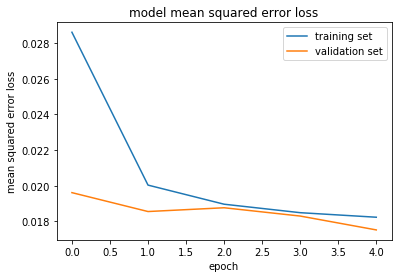

In [14]:
### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [26]:
score = model.evaluate(X_test, Y_test, verbose=1 )
print('Test loss: {}'.format(score) )


4920/4920 [==============================] - 0s 64us/step
Test loss: 0.018054016005641563
